In [27]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import math 
import tensorflow as tf 
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import random 
from yahoo_fin import stock_info as si
from sklearn.linear_model import LinearRegression

In [103]:
ticker = "SUNTECK.NS"
df = si.get_data(ticker)


In [104]:
df.head()

,open,high,low,close,adjclose,volume,ticker
2009-11-13,261.450012,267.399994,256.350006,258.174988,247.728439,308080.0,SUNTECK.NS
2009-11-16,258.500000,270.475006,258.500000,264.924988,254.205322,391138.0,SUNTECK.NS
2009-11-17,269.750000,274.475006,260.000000,260.600006,250.055420,341594.0,SUNTECK.NS
2009-11-18,271.350006,274.250000,258.500000,262.200012,251.590607,315010.0,SUNTECK.NS
2009-11-19,265.000000,269.500000,257.625000,259.774994,249.263718,264678.0,SUNTECK.NS


In [105]:
open_prices = df['open']
close_prices = df['close']
volumes = df['volume']
high_prices = df['high']
low_prices = df['low']
DATA_LEN = 300


close_prices = close_prices[len(
    close_prices) - DATA_LEN:len(close_prices)].to_list()
open_prices = open_prices[len(open_prices) -
                          DATA_LEN:len(open_prices)].to_list()
volumes = volumes[len(volumes) - DATA_LEN:len(volumes)].to_list()
high_prices = high_prices[len(high_prices) -
                          DATA_LEN:len(high_prices)].to_list()
low_prices = low_prices[len(low_prices) - DATA_LEN:len(low_prices)].to_list()


In [106]:
plt.style.use('dark_background')

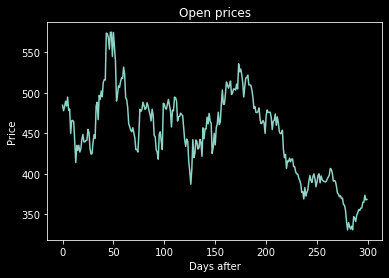

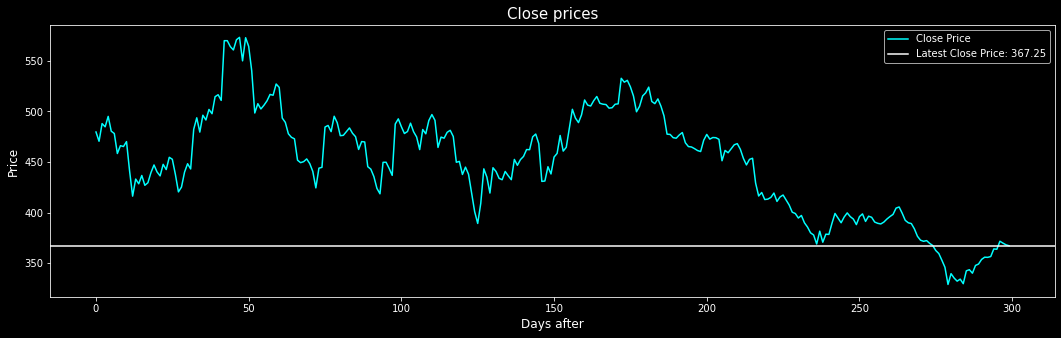

In [107]:
plt.title("Open prices")
plt.xlabel("Days after")
plt.ylabel("Price")
plt.plot(open_prices)
plt.show()


plt.figure(figsize=(18, 5))
plt.title("Close prices", fontsize=15)
plt.xlabel("Days after", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.plot(close_prices, 'cyan', label='Close Price')
plt.axhline(y=close_prices[len(close_prices) - 1], label=f'Latest Close Price: {close_prices[len(close_prices) - 1]}')
plt.legend()
plt.savefig("graphed-results/close-price")
plt.show()

In [108]:
len(close_prices)

300

In [109]:
close_for_calc = df['close']
close_for_calc = close_for_calc[len(
    close_for_calc) - DATA_LEN:len(close_for_calc)]


## Applying indicators to predict the general trend of the stock 

## First Metric :- Relative Strength Index (RSI) 

Equation to compute the RSI of a stock 
RSI = 100 – (100 / [1 +RS])

Resource :- https://www.wallstreetmojo.com/relative-strength-index/

### Start

In [110]:
import pandas_ta as pta
relative_strength_indexs = pta.rsi(close_for_calc, length = 14)
relative_strength_indexs = relative_strength_indexs.to_list()

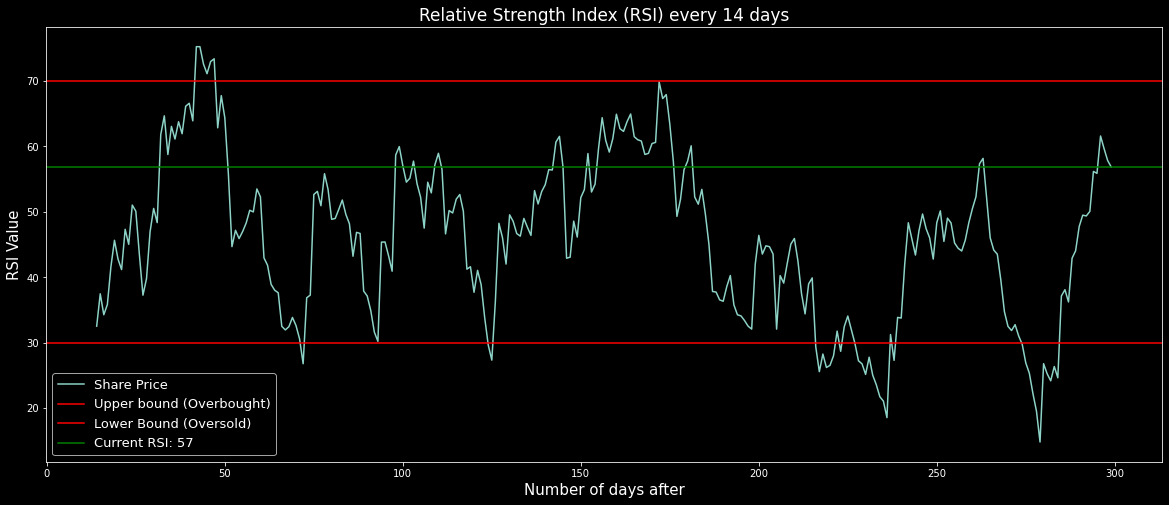

In [111]:
import matplotlib.pyplot as plt 
# %matplotlib notebook

plt.figure(figsize=(20, 8))
# plt.figure(figsize=(10, 5)) # This is when matplotlib notebook is activated
plt.plot(relative_strength_indexs, label='Share Price')
plt.axhline(y=70, color='r', label='Upper bound (Overbought)')
plt.axhline(y=30, color='r', label='Lower Bound (Oversold)')
plt.axhline(y=relative_strength_indexs[-1], color='g', label=f'Current RSI: {round(relative_strength_indexs[-1])}')
plt.title("Relative Strength Index (RSI) every 14 days", fontsize=17)
plt.xlabel("Number of days after", fontsize=15)
plt.ylabel("RSI Value", fontsize=15)
plt.legend(prop = {'size' : 13})
plt.savefig("graphed-results/RSI")
plt.show()

### End

## Creating Bollinger Bands

Simple Moving Average Equation + std 2

### start

In [112]:
import statistics

close_avg = close_for_calc.rolling(5).mean().to_list()
standard_deviations = close_for_calc.rolling(5).std().to_list()

upper_bollinger_band = []
lower_bollinger_band = []

for i in range(len(standard_deviations)):
    upper_bound = close_avg[i] + (standard_deviations[i] * 2)
    lower_bound = close_avg[i] - (standard_deviations[i] * 2)
    
    upper_bollinger_band.append(upper_bound)
    lower_bollinger_band.append(lower_bound)

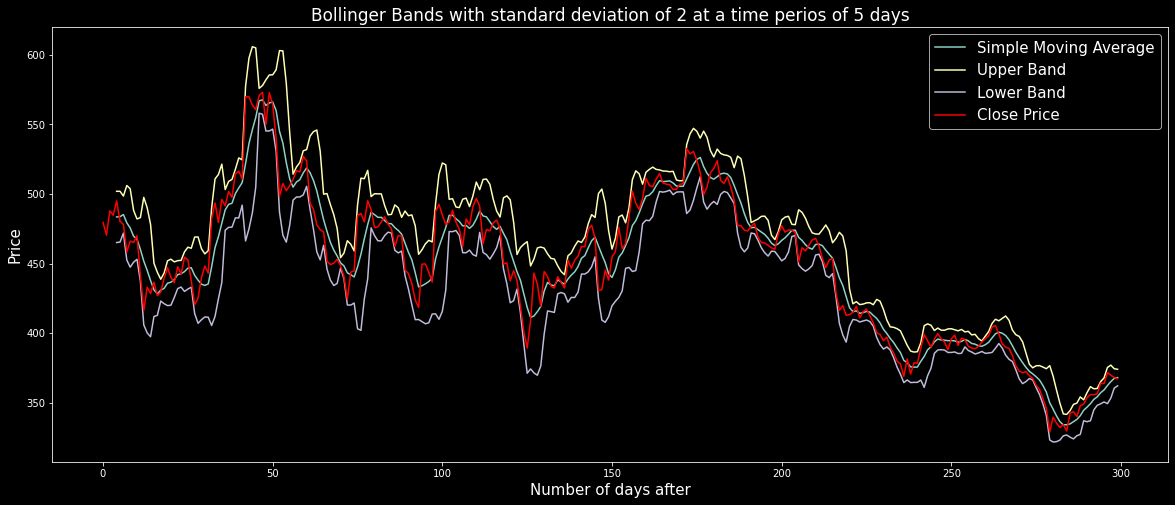

In [113]:
import matplotlib.pyplot as plt 


# Uncomment for interactive graphs
# %matplotlib notebook

plt.figure(figsize=(20, 8))
plt.plot(close_avg, label='Simple Moving Average')
plt.plot(upper_bollinger_band, label='Upper Band')
plt.plot(lower_bollinger_band, label='Lower Band')
plt.plot(close_prices, 'r', label='Close Price')
plt.title("Bollinger Bands with standard deviation of 2 at a time perios of 5 days", fontsize=17)
plt.xlabel("Number of days after", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.legend(prop = {'size' : 15})
plt.savefig("graphed-results/SMA + Bollinger Bands")
plt.show()

### end

## OBV :- On Balance Volume

In [114]:
on_balance_volumes = []
obv = 0

on_balance_volumes.append(obv)

for i in range(1, len(volumes)):
    if close_prices[i] > close_prices[i - 1]:
        obv += volumes[i]
        on_balance_volumes.append(obv)
        
    elif close_prices[i] < close_prices[i - 1]:
        obv -= volumes[i]
        on_balance_volumes.append(obv)
        
    else:
        obv += 0
        on_balance_volumes.append(obv)   
    

In [115]:
NUM_OF_DAYS_2 = 5
obv_df = pd.DataFrame(on_balance_volumes)
obv_sma = obv_df.rolling(NUM_OF_DAYS_2).mean()

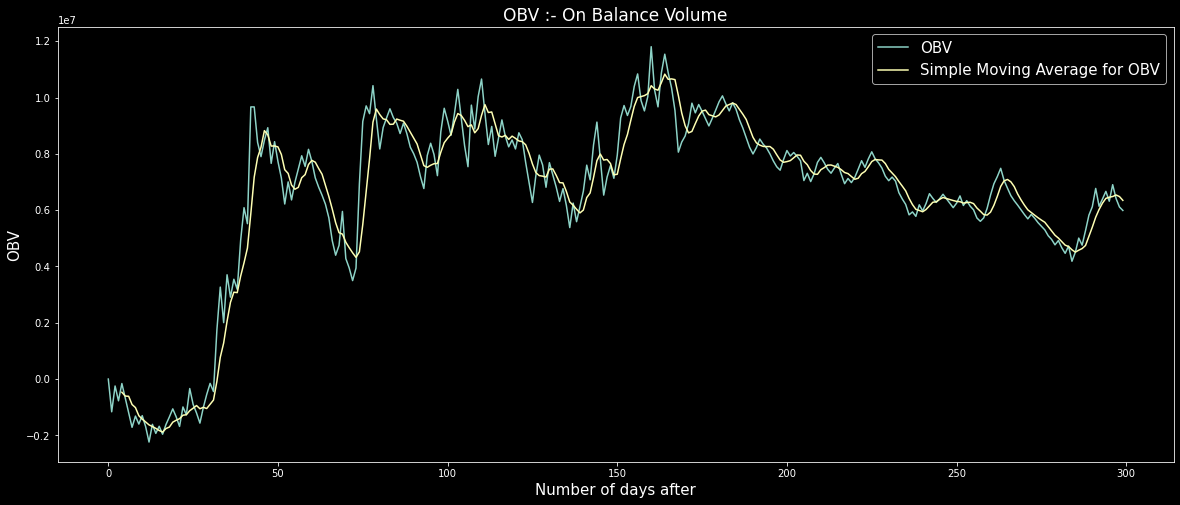

In [116]:
plt.figure(figsize=(20, 8))
plt.plot(on_balance_volumes, label='OBV')
plt.plot(obv_sma, label='Simple Moving Average for OBV')
plt.title("OBV :- On Balance Volume", fontsize=17)
plt.xlabel("Number of days after", fontsize=15)
plt.ylabel("OBV", fontsize=15)
plt.legend(prop = {'size' : 15})
plt.savefig("graphed-results/SMA(OBV) + OBV")
plt.show()

## Implementing MACD (Moving Average Convergence Divergence)

### Equation for MACD 
MACD=12-Period EMA − 26-Period EMA

In [117]:
ema12 = close_for_calc.ewm(span=12, adjust=False).mean()
ema26 = close_for_calc.ewm(span=26, adjust=False).mean()

macd = ema12 - ema26

# Signal line of macd
signal = macd.ewm(span=9, adjust=False).mean()

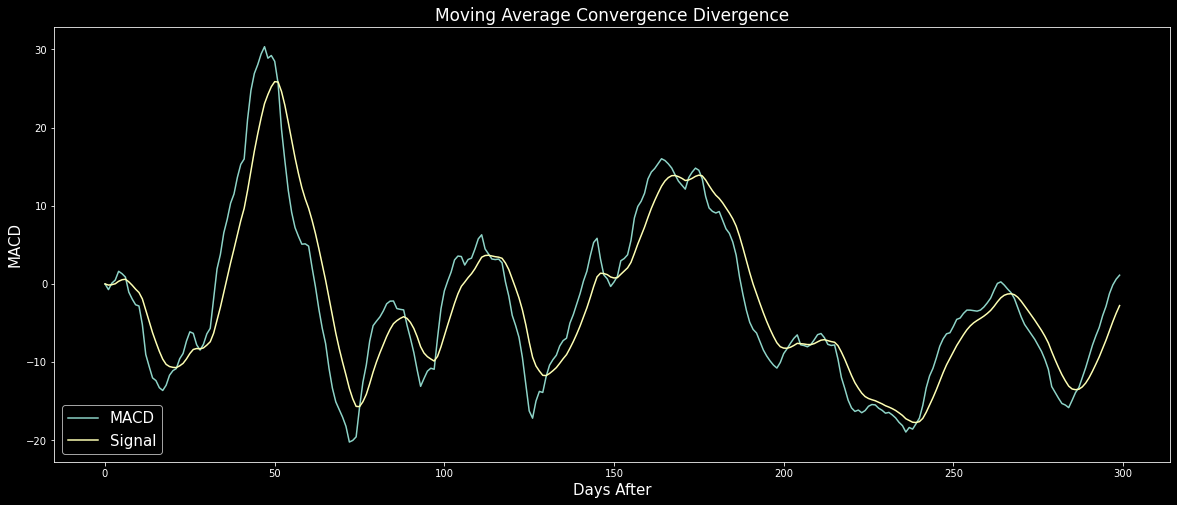

In [118]:
plt.figure(figsize=(20, 8))
plt.plot(macd.to_list(), label='MACD')
plt.plot(signal.to_list(), label='Signal')
plt.title("Moving Average Convergence Divergence", fontsize=17)
plt.ylabel("MACD", fontsize=15)
plt.xlabel("Days After", fontsize=15)
plt.legend(prop = {'size' : 15}, loc = 'lower left')
plt.savefig("graphed-results/MACD")
plt.show()

## Momentum

In [119]:
MOMENTUM_PERIOD = 10

momentum_values = []
for i in range(MOMENTUM_PERIOD, len(close_prices)):
    curr_close_price = close_prices[i]
    period_start_close_price = close_prices[i - MOMENTUM_PERIOD]
    momentum_values.append(curr_close_price - (period_start_close_price))

In [120]:
# Computing the average mometum 

momentum_sum = 0
for i in range(len(momentum_values)):
    momentum_sum += momentum_values[i]


avg_momentum = momentum_sum / len(momentum_values)

print(avg_momentum)

-3.927241463496767


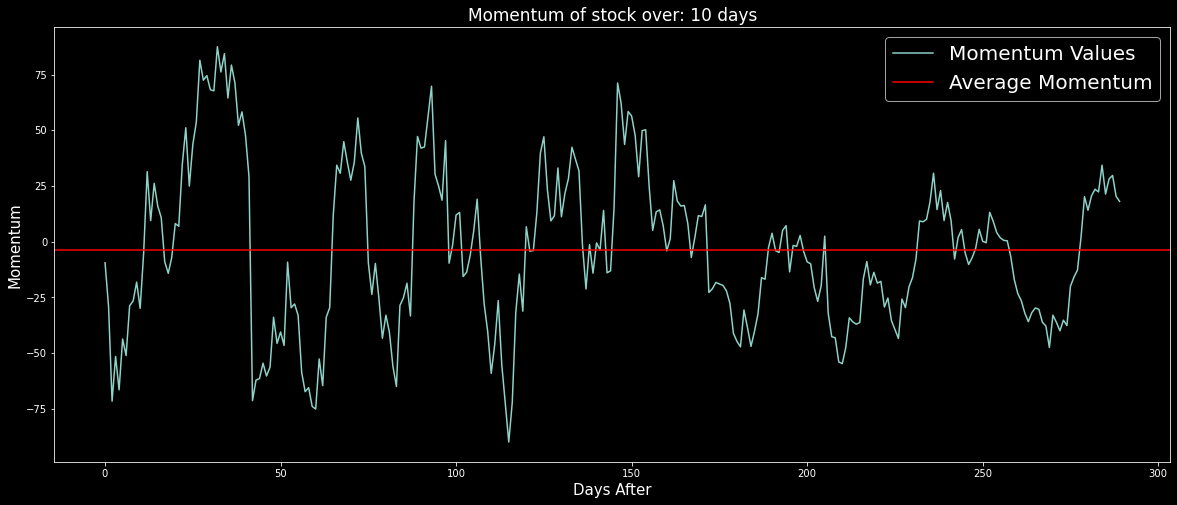

In [121]:
plt.figure(figsize=(20, 8))
plt.plot(momentum_values, label='Momentum Values')
plt.axhline(y=avg_momentum, label='Average Momentum', color='r')
plt.title(f"Momentum of stock over: {MOMENTUM_PERIOD} days", fontsize=17)
plt.ylabel("Momentum", fontsize=15)
plt.xlabel("Days After", fontsize=15)
plt.legend(prop={'size':20})
plt.savefig("graphed-results/momentum")
plt.show()


## Resistance and Support Lines

In [122]:
type(close_prices)

list

### Computing the pivots Using the equation Pivot Point = (Previous Session High + Previous Session Low + Previous Session Close)/3

In [123]:
pivot_points = []

for i in range(len(close_for_calc)):
    if i == 0:
        pivot_points.append(float("nan"))
    else:
        prev_high = high_prices[i-1]
        prev_low = low_prices[i-1]
        prev_close = close_prices[i-1]
        
        pivot_point = (prev_high + prev_low + prev_close) / 3
        pivot_points.append(pivot_point)

### Computing the Resistance and Support levels using the equations below -


##### Resistance Level 1 = (2 x Pivot Point) – Previous Session Low
##### Support Level 1 – (2 x Pivot Point) – Previous High
##### Resistance Level 2 = (Pivot Point – Support Level 1) + Resistance Level 1 
##### Support Level 2 = Pivot Point – (Resistance Level 1 – Support Level 1) 
##### Resistance Level 3 = (Pivot Point – Support Level 2) + Resistance Level 2 
##### Support Level 3 = Pivot Point – (Resistance Level 2 – Support Level 2) 

In [124]:
resistance_1 = []
support_1 = []
resistance_2 = []
support_2 = []


for i in range(len(pivot_points)):
    if i == 0:
        resistance_1.append(float("nan"))
        support_1.append(float("nan"))
    else:
        r1 = (2 * pivot_points[i]) - low_prices[i-1]
        s1 = (2 * pivot_points[i]) - high_prices[i-1]
        
        r2 = (pivot_points[i] - s1) + r1
        s2 = pivot_points[i] - (r1 - s1)
        
        resistance_1.append(r1)
        support_1.append(s1)
        resistance_2.append(r2)
        support_2.append(s2)

In [125]:
print(type(support_1))
print(len(close_prices))

<class 'list'>
300


In [126]:
first_support_cross_counter = 0 

for i in range(len(support_1)):
    if support_1[i] > close_prices[i]:
        first_support_cross_counter += 1
        
        
print(first_support_cross_counter)

64


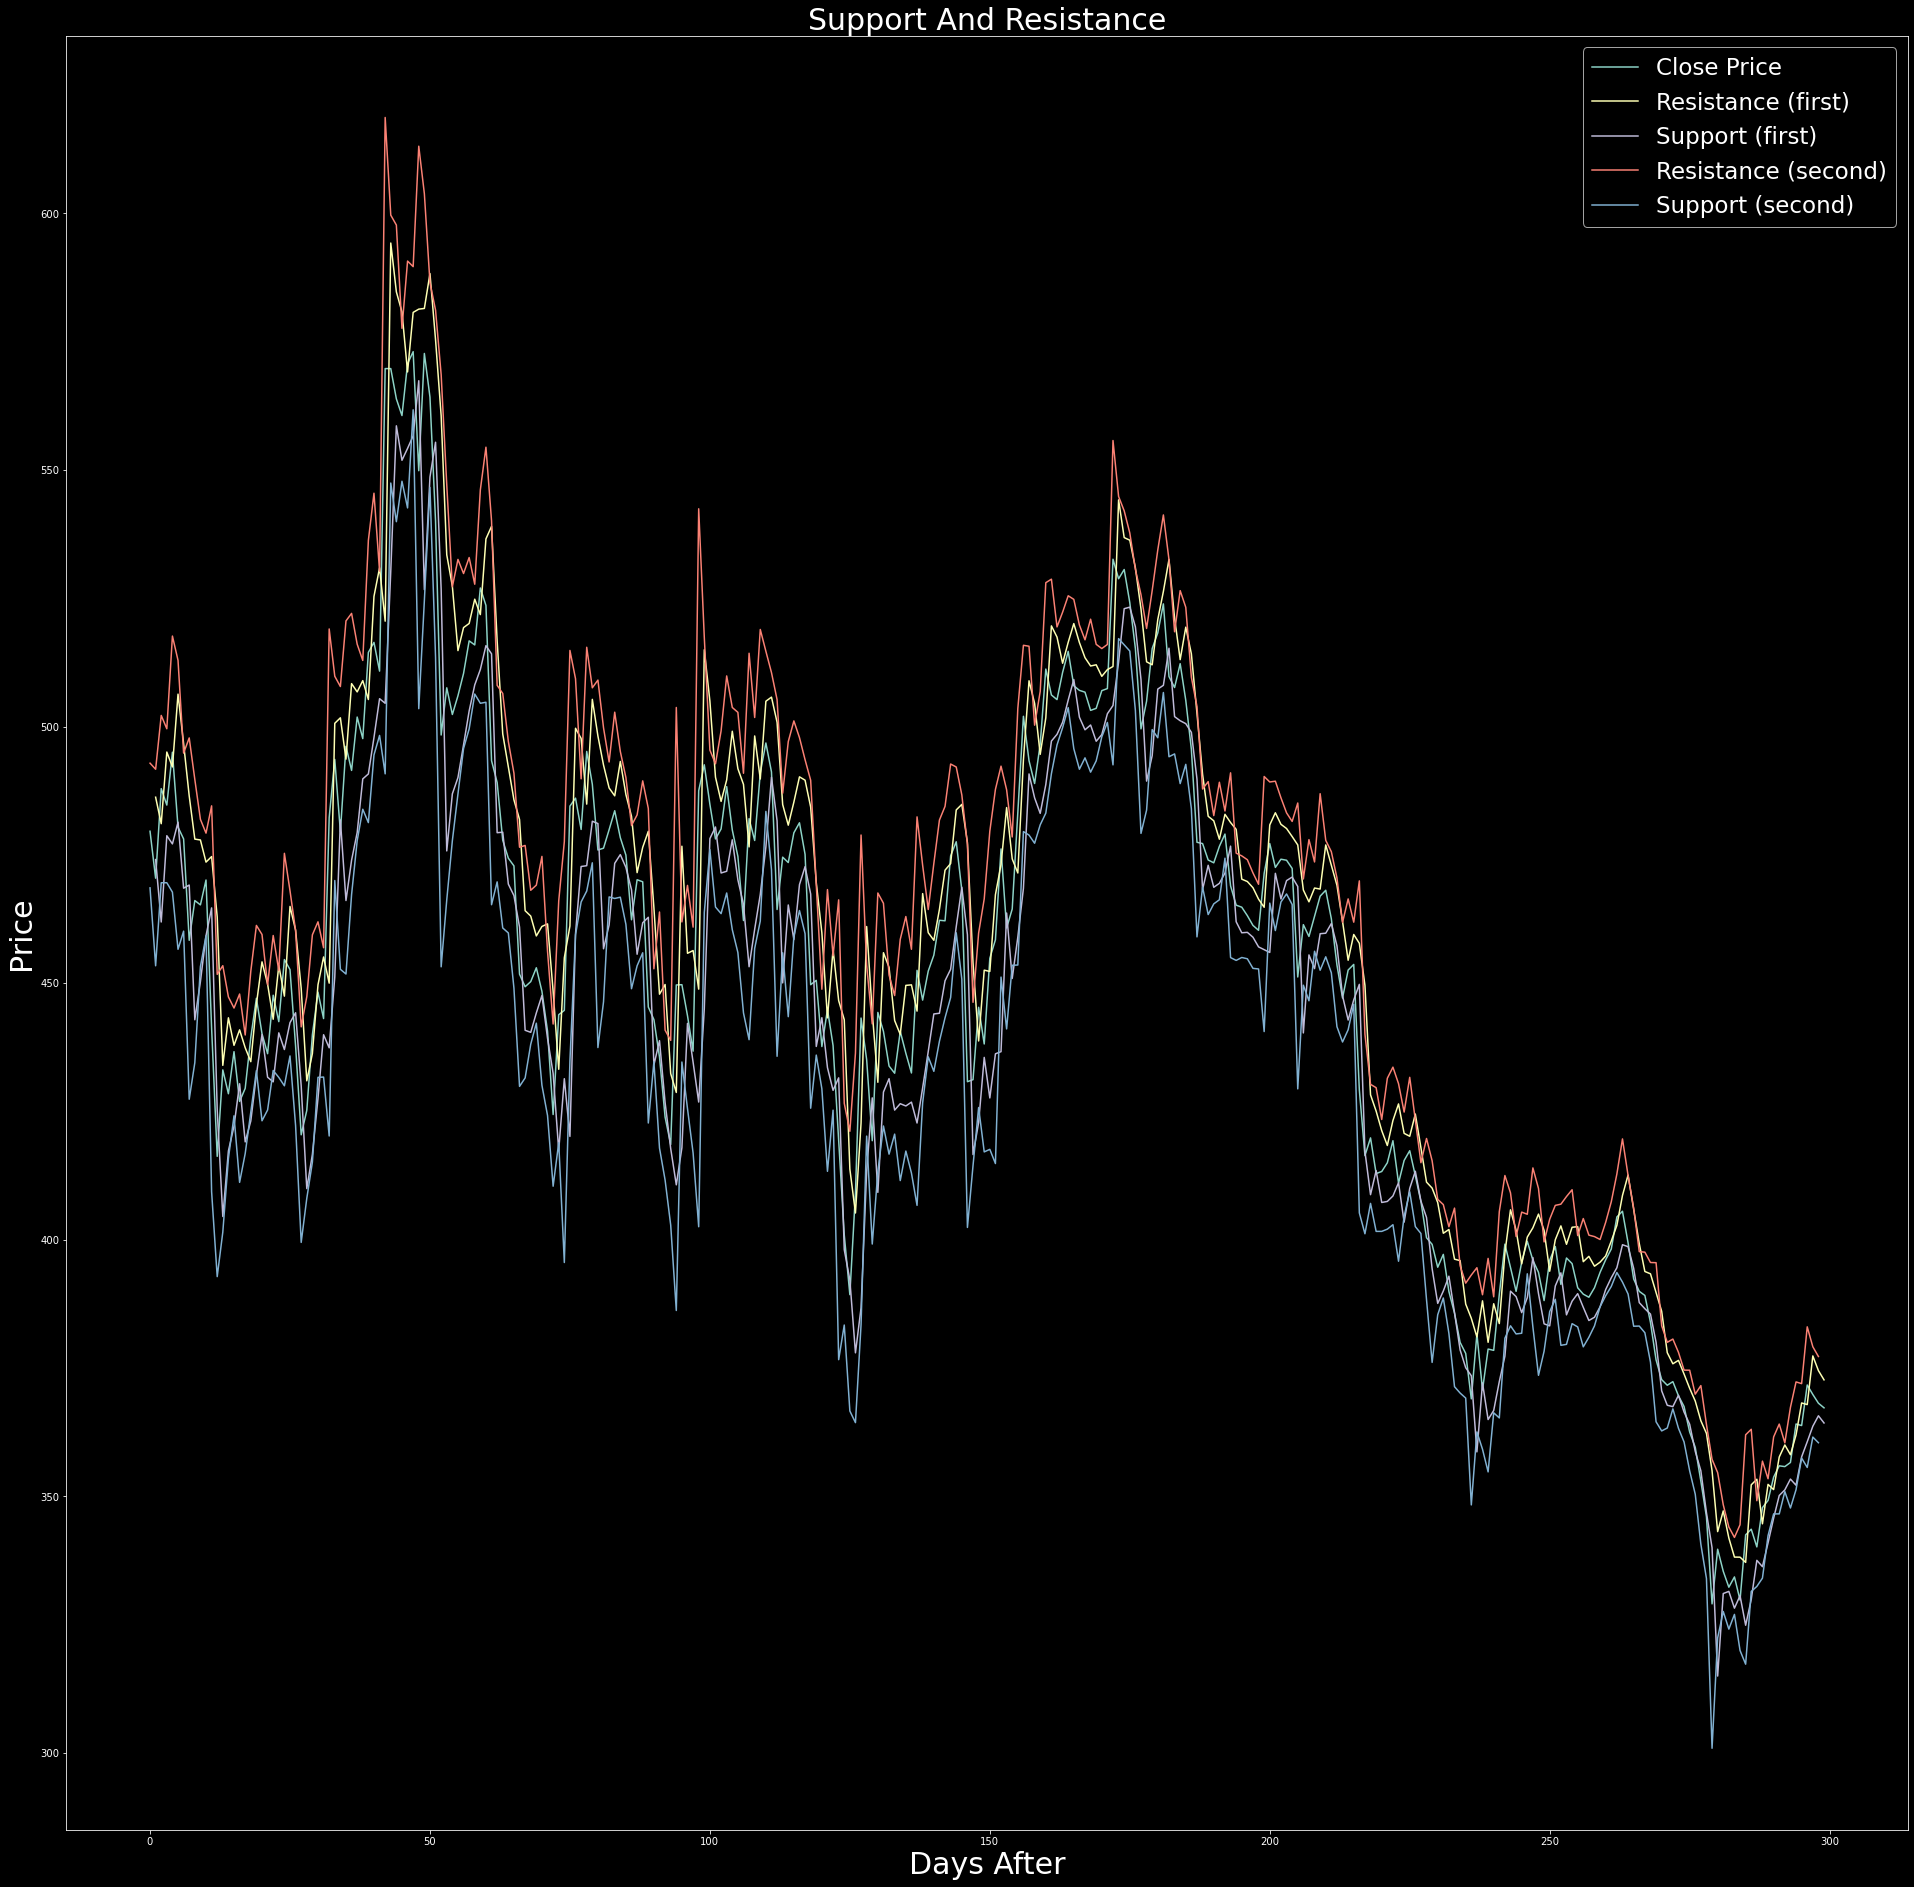

In [127]:
plt.figure(figsize=(33, 33))
plt.plot(close_prices, label='Close Price')
plt.plot(resistance_1, label='Resistance (first)')
plt.plot(support_1, label='Support (first)')
plt.plot(resistance_2, label='Resistance (second)')
plt.plot(support_2, label='Support (second)')
plt.xlabel("Days After", fontsize=30)
plt.ylabel("Price", fontsize=30)
plt.title("Support And Resistance", fontsize=30)
plt.legend(prop = {'size' : 23})
plt.savefig("graphed-results/support and resistance")
plt.show()

## Neural Network to predict the future

In [128]:
dataset = close_prices

dataset = np.array(dataset)
training = len(dataset)

In [129]:
dataset = np.reshape(dataset, (dataset.shape[0], 1))

In [130]:
print(dataset.shape)

(300, 1)


In [131]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data
print(len(train_data))
# prepare feature and labels
x_train = []
y_train = []
prediction_days = 60

for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i-prediction_days:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


300


In [132]:
print(x_train.shape)

(240, 60, 1)


## LSTM Approach

In [133]:
# RNN Using LSTMs

# SAMPLE HIGH ACCURACY MODEL
# ---------------------------------
model_rnn = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(units=75,
                    return_sequences=True,
                    input_shape=(x_train.shape[1], 1))), 
    keras.layers.Bidirectional(keras.layers.LSTM(units=64)),
    keras.layers.Dense(300),
    keras.layers.Dense(32),
    keras.layers.Dense(1),
])
# ---------------------------------


In [134]:
# Adding early stopping to prevent time waste in case there is no model improvement
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.0008,
    patience=3,
)

model_rnn.compile(optimizer='adam',
                  loss='mse')
history = model_rnn.fit(x_train,
                        y_train,
                        epochs=20,
                        batch_size=5,
                        callbacks=[early_stopping])


Epoch 1/20
48/48 [==============================] - 8s 31ms/step - loss: 0.0129
Epoch 2/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0052
Epoch 3/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0044
Epoch 4/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0054
Epoch 5/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0033
Epoch 6/20
48/48 [==============================] - 1s 29ms/step - loss: 0.0037
Epoch 7/20
48/48 [==============================] - 1s 29ms/step - loss: 0.0036
Epoch 8/20
48/48 [==============================] - 1s 29ms/step - loss: 0.0042


## Transformer Approach
Trying to fix the volitality issue by paying attention to price actions happening in small periods of time

In [146]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = keras.layers.LayerNormalization(epsilon=1e-6)(inputs)

    # "ATTENTION LAYER"
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = keras.layers.Dropout(dropout)(x)
    res = x + inputs

    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work.
    x = keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="elu")(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    outputs = keras.layers.Dense(1, activation="linear")(
        x)  # this is a pass-through
    return keras.Model(inputs, outputs)


input_shape = x_train.shape[1:]



In [147]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=3),
]


model = build_model(
    input_shape,
    head_size=46,  # Embedding size for attention
    num_heads=60,  # Number of attention heads
    ff_dim=55,  # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=7,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mean_squared_error"],
)


history = model.fit(
    x_train,
    y_train,
    validation_split=0.01,
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
)


Epoch 1/10
8/8 [==============================] - 20s 2s/step - loss: 0.3022 - mean_squared_error: 0.3022 - val_loss: 1.1177 - val_mean_squared_error: 1.1177
Epoch 2/10
8/8 [==============================] - 15s 2s/step - loss: 0.1261 - mean_squared_error: 0.1261 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 3/10
8/8 [==============================] - 14s 2s/step - loss: 0.0831 - mean_squared_error: 0.0831 - val_loss: 0.0378 - val_mean_squared_error: 0.0378
Epoch 4/10
8/8 [==============================] - 15s 2s/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 0.1593 - val_mean_squared_error: 0.1593
Epoch 5/10
8/8 [==============================] - 16s 2s/step - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0763 - val_mean_squared_error: 0.0763
Epoch 6/10
8/8 [==============================] - 16s 2s/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0435 - val_mean_squared_error: 0.0435


In [68]:
# model.save("transformer-model-v1.1/")

## Transformer Predictions

In [148]:
test_data = scaled_data


x_test = []
y_test = []
for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i, 0])
    y_test.append(test_data[i, 0])

x_test = np.array(x_test)
print(x_test.shape)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
transformer_predictions = model.predict(x_test)
transformer_predictions = scaler.inverse_transform(transformer_predictions)

(240, 60)
8/8 [==============================] - 8s 954ms/step


In [149]:
y_test = np.array(y_test)

In [150]:
type(y_test)

numpy.ndarray

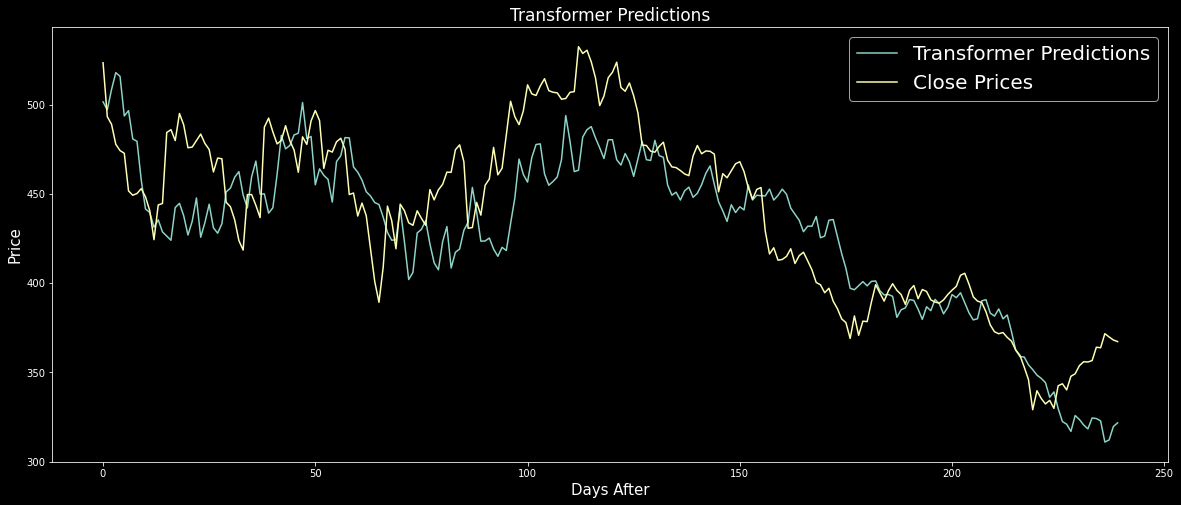

In [151]:
plt.figure(figsize=(20, 8))
plt.plot(transformer_predictions, label='Transformer Predictions')
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Close Prices')
plt.title("Transformer Predictions", fontsize=17)
plt.xlabel("Days After", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()


## Transformer Future Predictions

In [152]:
curr_price = close_prices[len(close_prices) -
                          prediction_days:len(close_prices)]

curr_price = np.array(curr_price)
curr_price = scaler.transform(curr_price.reshape(1, -1))


curr_price = np.reshape(
    curr_price, (curr_price.shape[0], curr_price.shape[1], 1))


In [153]:
next_day_pred = model.predict(curr_price)
next_day_pred = scaler.inverse_transform(next_day_pred)

1/1 [==============================] - 0s 44ms/step


In [154]:
transformer_pred_prices = []
NUM_OF_FUTURE_DAYS = 10
transformer_tot_close_prices = list(close_prices)

# model = load_model("lstm-test-model-v1.1")
for i in range(NUM_OF_FUTURE_DAYS + 1):
    curr_price = transformer_tot_close_prices[len(
        transformer_tot_close_prices) - prediction_days: len(transformer_tot_close_prices)]
    curr_price = np.array(curr_price, dtype='object')
    curr_price = scaler.transform(curr_price.reshape(1, -1))
    curr_price = np.reshape(
        curr_price, (curr_price.shape[0], curr_price.shape[1], 1))
    next_day_pred = model.predict(curr_price)
    next_day_pred = scaler.inverse_transform(next_day_pred)
    transformer_pred_prices.append(next_day_pred)
    transformer_tot_close_prices.append(next_day_pred)
    curr_price = 0


1/1 [==============================] - 0s 42ms/step


/Users/yashsolanki/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


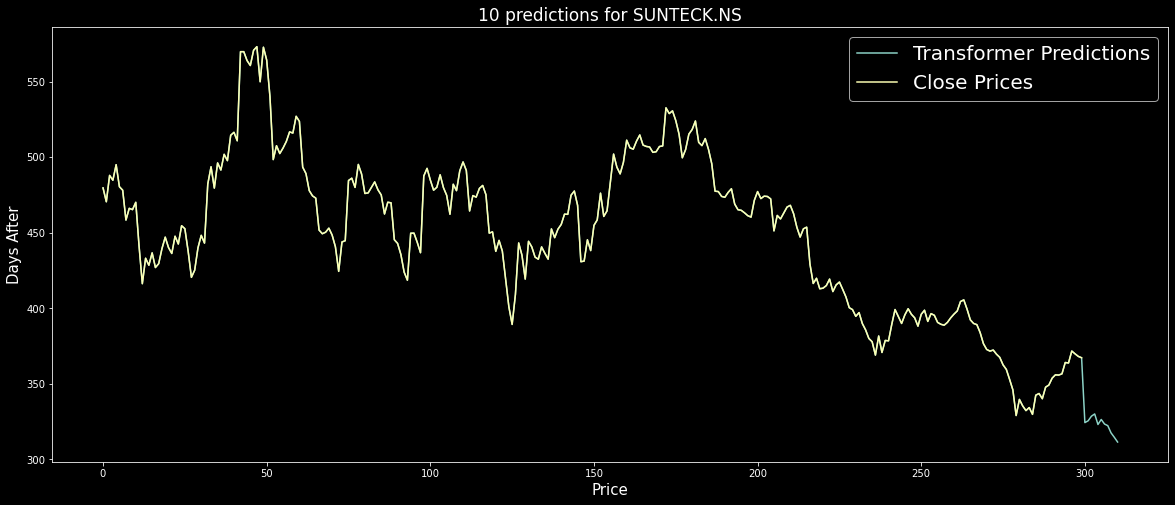

In [155]:
pred_prices = np.array(transformer_pred_prices)
pred_prices = np.reshape(pred_prices, (pred_prices.shape[0]))


plt.figure(figsize=(20, 8))
plt.plot(transformer_tot_close_prices, label='Transformer Predictions')
plt.plot(close_prices, label='Close Prices')
plt.title(f"{NUM_OF_FUTURE_DAYS} predictions for {ticker}", fontsize=17)
plt.xlabel("Price", fontsize=15)
plt.ylabel("Days After", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()


In [90]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 60, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 60, 1)       19321       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

 mbda)                                                            'tf.__operators__.add_5[0][0]'] 
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 60, 1)       2           ['tf.__operators__.add_6[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv1d_6 (Conv1D)              (None, 60, 55)       110         ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_7 (Dropout)            (None, 60, 55)       0           ['conv1d_6[0][0]']               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 60, 1)        56          ['dropout_7[0][0]']              
          

 global_average_pooling1d (Glob  (None, 60)          0           ['tf.__operators__.add_13[0][0]']
 alAveragePooling1D)                                                                              
                                                                                                  
 dense_6 (Dense)                (None, 256)          15616       ['global_average_pooling1d[0][0]'
                                                                 ]                                
                                                                                                  
 dropout_14 (Dropout)           (None, 256)          0           ['dense_6[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 1)            257         ['dropout_14[0][0]']             
                                                                                                  
Total para

## RNN Future Predictions

In [135]:
test_data = scaled_data
x_test = []
y_test = []
for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i, 0])
    y_test.append(test_data[i, 0])
  
x_test = np.array(x_test)
print(x_test.shape)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model_rnn.predict(x_test)
predictions = scaler.inverse_transform(predictions)

(240, 60)
8/8 [==============================] - 3s 21ms/step


In [136]:
y_test = np.array(y_test)

In [137]:
print(predictions[0:5])

[[509.79697]
 [513.2481 ]
 [502.31863]
 [492.45596]
 [481.34988]]


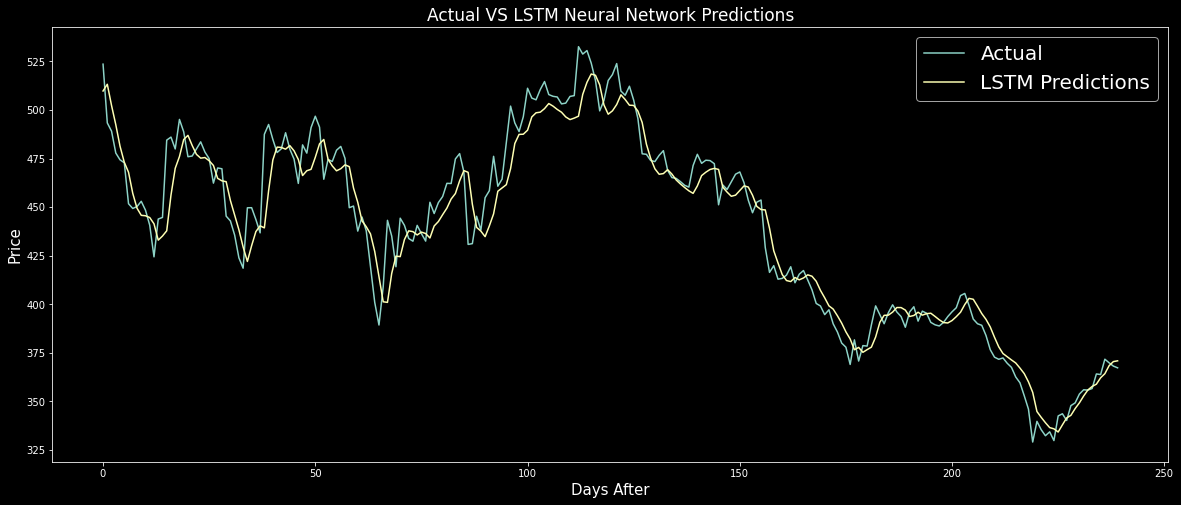

In [138]:
plt.figure(figsize=(20, 8))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(predictions, label='LSTM Predictions')
plt.title("Actual VS LSTM Neural Network Predictions", fontsize=17)
plt.xlabel("Days After", fontsize=15) 
plt.ylabel("Price", fontsize=15)
plt.legend(prop = {'size' : 20})
plt.show()

In [139]:
curr_price = close_prices[len(close_prices) - prediction_days:len(close_prices)]

curr_price = np.array(curr_price)
curr_price = scaler.transform(curr_price.reshape(1, -1))

In [140]:
curr_price = np.reshape(curr_price, (curr_price.shape[0], curr_price.shape[1], 1))

In [141]:
next_day_pred = model_rnn.predict(curr_price)
next_day_pred = scaler.inverse_transform(next_day_pred)

1/1 [==============================] - 0s 33ms/step


In [142]:
print(close_prices[len(close_prices) - 1])
print(next_day_pred[0][0])

367.25
370.3975


In [144]:
pred_prices = []
NUM_OF_FUTURE_DAYS = 15
tot_close_prices = list(close_prices)

# model = load_model("lstm-test-model-v1.1")
for i in range(NUM_OF_FUTURE_DAYS + 1):
    curr_price = tot_close_prices[len(tot_close_prices) - prediction_days: len(tot_close_prices)]
    curr_price = np.array(curr_price, dtype='object')
    curr_price = scaler.transform(curr_price.reshape(1, -1))
    curr_price = np.reshape(curr_price, (curr_price.shape[0], curr_price.shape[1], 1))
    next_day_pred = model_rnn.predict(curr_price)
    next_day_pred = scaler.inverse_transform(next_day_pred)
    pred_prices.append(next_day_pred)
    tot_close_prices.append(next_day_pred)
    curr_price = 0

1/1 [==============================] - 0s 29ms/step


/Users/yashsolanki/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


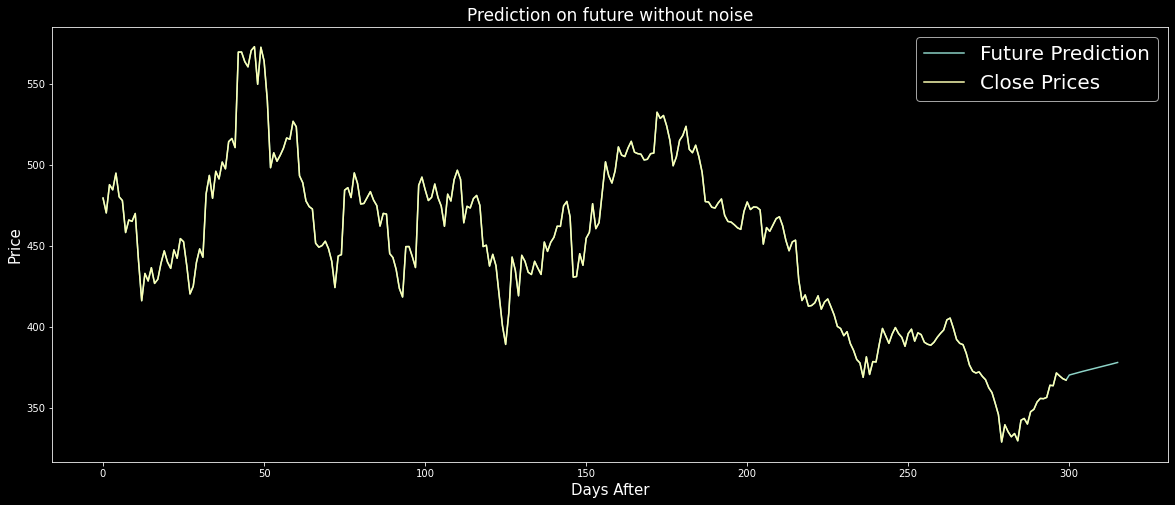

In [145]:
plt.figure(figsize=(20, 8))
plt.plot(tot_close_prices, label='Future Prediction')
plt.plot(close_prices, label='Close Prices')
plt.title("Prediction on future without noise", fontsize=17)
plt.xlabel("Days After", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.legend(prop = {'size' : 20})
plt.savefig(f"graphed-results/future trend over {NUM_OF_FUTURE_DAYS} days")
plt.show()


## Linear Regression Model to predict the future price

In [101]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))

In [102]:
reg = LinearRegression().fit(x_train, y_train)

In [103]:
print(reg.score(x_train, y_train))

0.9918375007006592


0

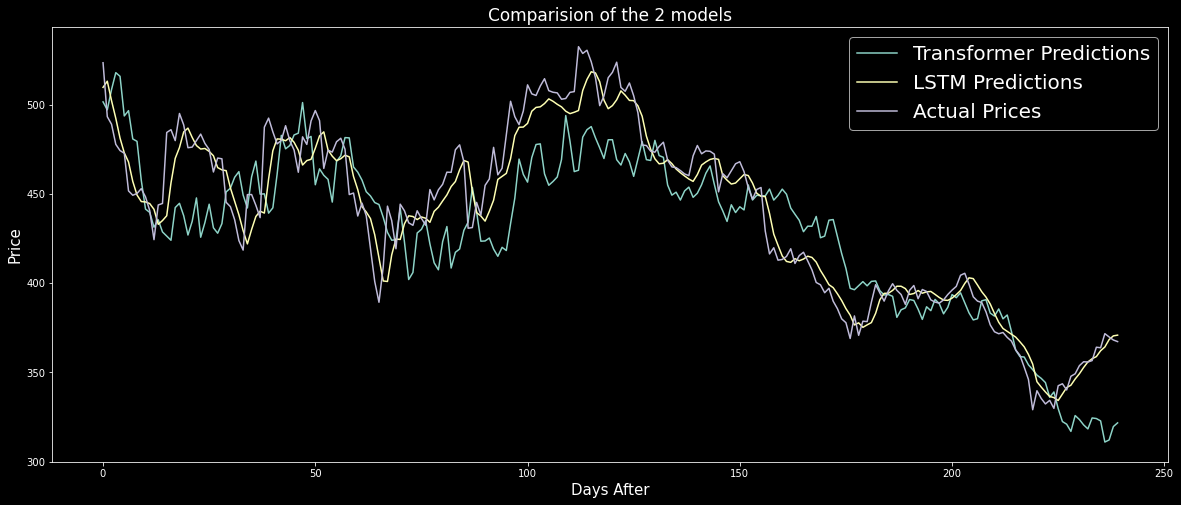

In [160]:
plt.figure(figsize=(20, 8))
plt.plot(transformer_predictions, label='Transformer Predictions')
plt.plot(predictions, label='LSTM Predictions')
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Prices')
plt.legend(prop={'size': 20})
plt.xlabel("Days After", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.title("Comparision of the 2 models", fontsize=17)
plt.show()


## Computing Volitality over the prediction days period of the Stock to implement as noise

In [156]:
volitality_calc_period = 60
price_sum = 0

for i in range(len(close_prices) - volitality_calc_period, len(close_prices)):
    price_sum += close_prices[i]
    
price_avg = price_sum / volitality_calc_period

print(price_avg)

373.61499989827473


In [157]:
diffs = []

for i in range(len(close_prices) - volitality_calc_period, len(close_prices)):
    diffs.append(pow(close_prices[i] - price_avg, 2))

diffs = np.array(diffs)
diffs_sum = np.sum(diffs)

In [158]:
variance = diffs_sum / prediction_days

standard_deviation = math.sqrt(variance)

print(standard_deviation)

22.25103239689655


## Generating noise based on the standard deviation of the data over the specified period

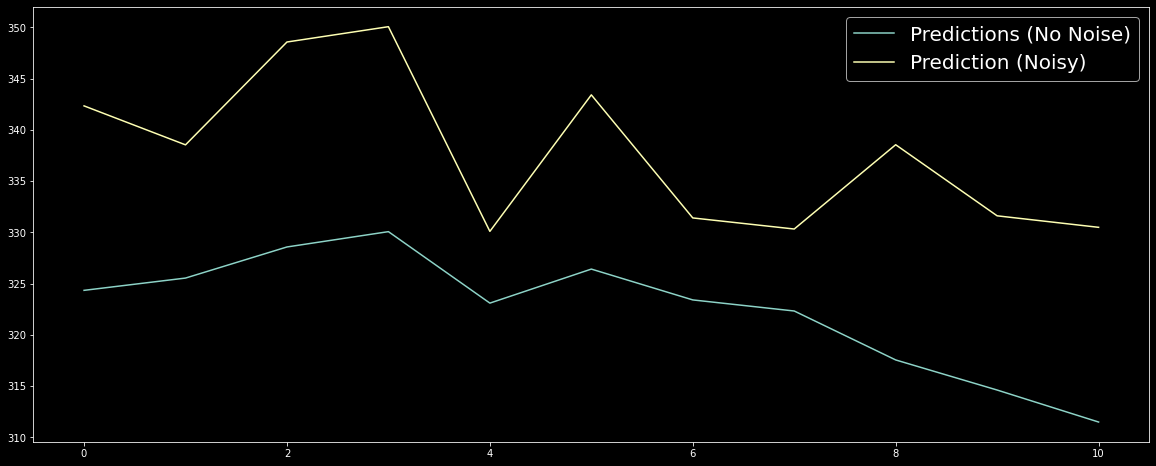

In [159]:
pred_prices_noisy = []
lower_bound = int(round(0.3 * standard_deviation))
for i in range(len(pred_prices)):
    noise = random.randint(lower_bound, round(standard_deviation))
    pred_prices_noisy.append(pred_prices[i] + noise)
    
pred_prices_noisy = np.array(pred_prices_noisy)
pred_prices_noisy = np.reshape(pred_prices_noisy, (pred_prices_noisy.shape[0]))
pred_prices = np.array(pred_prices)
pred_prices = np.reshape(pred_prices, (pred_prices.shape[0]))


plt.figure(figsize=(20, 8))
plt.plot(pred_prices, label='Predictions (No Noise)')
plt.plot(pred_prices_noisy, label='Prediction (Noisy)')
plt.legend(prop = {'size': 20})
plt.show()

## Auto trading strategy

## Strategy

### 1 :- Checking if rsi > 45 indicating a buy position. 
### 2 :- Checking if the momentum on the rsi is strong. 

In [212]:
# Adding sma for 10 and 30 days 
def calc_sma(data, days):
    sma = data.rolling(days).mean().to_list()
    return sma


sma_5 = calc_sma(close_for_calc, 5)
sma_10 = calc_sma(close_for_calc, 10)
sma_20 = calc_sma(close_for_calc, 20)
sma_30 = calc_sma(close_for_calc, 30)


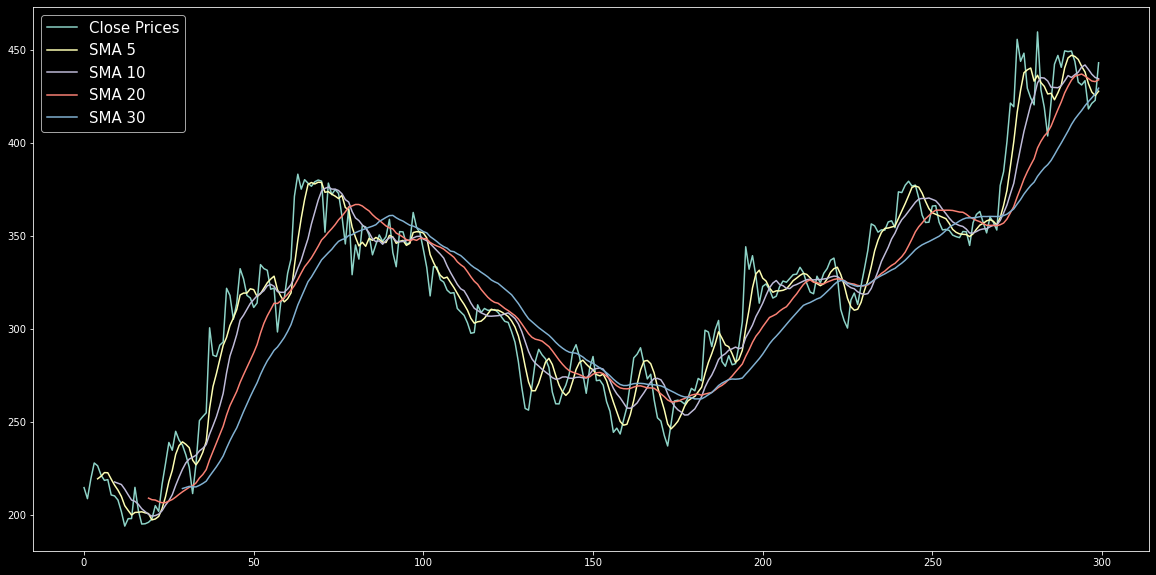

In [213]:
plt.figure(figsize=(20, 10))
plt.plot(close_prices, label='Close Prices')
plt.plot(sma_5, label='SMA 5')
plt.plot(sma_10, label='SMA 10')
plt.plot(sma_20, label='SMA 20')
plt.plot(sma_30, label='SMA 30')
plt.legend(prop={'size': 15})
plt.show()


In [214]:
# Create the data frame containing the parameters to take into account 
trade_params = pd.DataFrame(list(zip(close_prices, sma_5, sma_10, sma_20, sma_30, momentum_values, relative_strength_indexs, 
                            upper_bollinger_band, lower_bollinger_band)), 
                            columns=['Close Prices', 'SMA 5', 'SMA 10', 'SMA 20', 'SMA 30', 'Momentum', 'RSI', 
                            'Upper Bollinger Band', 'Lower Bollinger Band'])


In [215]:
trade_params

,Close Prices,SMA 5,SMA 10,SMA 20,SMA 30,Momentum,RSI,Upper Bollinger Band,Lower Bollinger Band
0,214.600006,NaN,NaN,NaN,NaN,-6.700012,NaN,NaN,NaN
1,208.649994,NaN,NaN,NaN,NaN,-6.949997,NaN,NaN,NaN
2,219.300003,NaN,NaN,NaN,NaN,-25.400009,NaN,NaN,NaN
3,227.850006,NaN,NaN,NaN,NaN,-29.950012,NaN,NaN,NaN
4,226.350006,219.350003,NaN,NaN,NaN,-28.400009,NaN,235.421881,203.278125
...,...,...,...,...,...,...,...,...,...
285,422.299988,426.759991,430.029999,409.099997,390.659999,11.250000,55.597205,467.997922,385.522060
286,442.450012,423.289996,429.879999,413.639998,393.726665,-24.100006,60.293267,451.483932,395.096060
287,447.149994,426.969995,429.759998,417.987497,396.976665,-25.799988,61.320825,462.560358,391.379633
288,440.750000,431.289996,430.889996,422.159998,400.031665,-17.750000,59.078794,467.374591,395.205402


In [216]:
print(trade_params['RSI'].iloc[13])

nan


In [217]:
buy_signal = []
sell_signal = []
trigger = 0

# Currently rudimentary
for i in range(len(trade_params)):
    if (trade_params['SMA 5'].iloc[i] < trade_params['SMA 20'].iloc[i]) and trigger != 1:
        sell_signal.append(float("nan"))
        buy_signal.append(close_prices[i])
        trigger = 1

    elif (trade_params['SMA 5'].iloc[i] > trade_params['SMA 20'].iloc[i]) and trigger != -1:
        sell_signal.append(close_prices[i])
        buy_signal.append(float("nan"))
        trigger = -1
    else:
        buy_signal.append(float("nan"))
        sell_signal.append(float("nan"))    


In [218]:
trade_params['Buy Signal'] = buy_signal
trade_params['Sell Signal'] = sell_signal

In [219]:
trade_params[0:10]

,Close Prices,SMA 5,SMA 10,SMA 20,SMA 30,Momentum,RSI,Upper Bollinger Band,Lower Bollinger Band,Buy Signal,Sell Signal
0,214.600006,NaN,NaN,NaN,NaN,-6.700012,NaN,NaN,NaN,NaN,NaN
1,208.649994,NaN,NaN,NaN,NaN,-6.949997,NaN,NaN,NaN,NaN,NaN
2,219.300003,NaN,NaN,NaN,NaN,-25.400009,NaN,NaN,NaN,NaN,NaN
3,227.850006,NaN,NaN,NaN,NaN,-29.950012,NaN,NaN,NaN,NaN,NaN
4,226.350006,219.350003,NaN,NaN,NaN,-28.400009,NaN,235.421881,203.278125,NaN,NaN
5,221.399994,220.710001,NaN,NaN,NaN,-6.649994,NaN,235.898723,205.521278,NaN,NaN
6,218.500000,222.680002,NaN,NaN,NaN,-16.149994,NaN,231.090299,214.269704,NaN,NaN
7,218.899994,222.600000,NaN,NaN,NaN,-23.899994,NaN,231.177014,214.022986,NaN,NaN
8,210.649994,219.159998,NaN,NaN,NaN,-15.500000,NaN,230.545829,207.774166,NaN,NaN
9,210.149994,215.919995,217.634999,NaN,NaN,-14.199997,NaN,226.246322,205.593668,NaN,NaN


In [220]:
print(len(trade_params['SMA 20']))
print(len(close_prices))

290
300


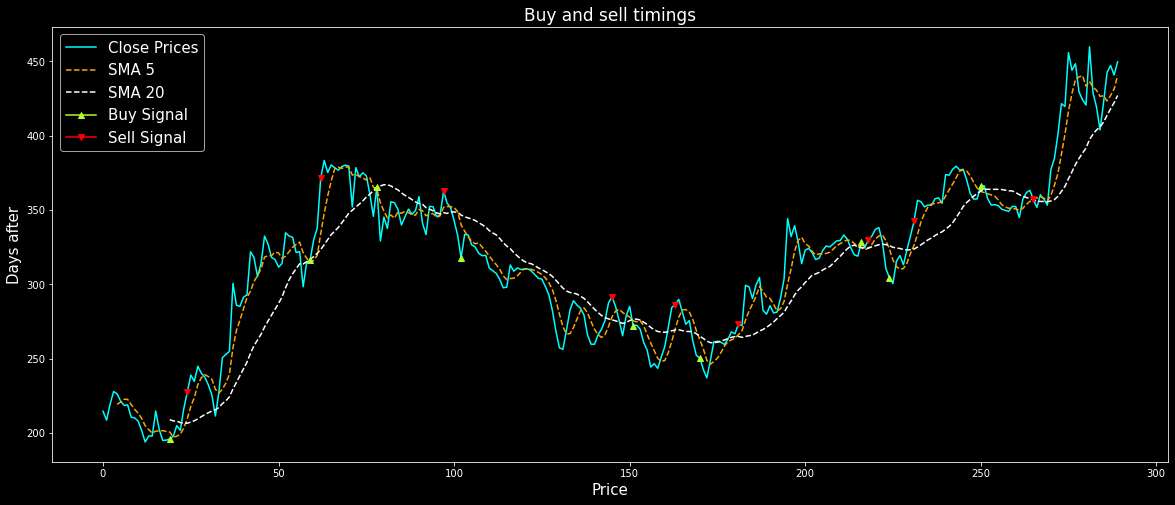

In [221]:
plt.figure(figsize=(20, 8))
plt.plot(trade_params['Close Prices'], label='Close Prices', color='cyan')
plt.plot(trade_params['SMA 5'], linestyle='--', label='SMA 5', color='orange')
plt.plot(trade_params['SMA 20'], linestyle='--',label='SMA 20', color='white')
plt.plot(trade_params['Buy Signal'], marker='^', color='greenyellow', label='Buy Signal')
plt.plot(trade_params['Sell Signal'], marker='v', color='r', label='Sell Signal')
plt.legend(prop={'size': 15})
plt.title("Buy and sell timings", fontsize=17)
plt.ylabel("Days after", fontsize=15)
plt.xlabel("Price", fontsize=15)
plt.savefig("graphed-results/Algorithmic Traded Results")
plt.show()


## Generate an analytics report based on the collected data

In [62]:
from fpdf import FPDF

In [63]:
FONT_FAMILY = "Arial"
WIDTH = 210
HEIGHT = 297

In [64]:
pdf = FPDF()
pdf.add_page()
pdf.set_font(FONT_FAMILY, size=40)
pdf.ln(40)
pdf.multi_cell(w=0, h=15, txt=f"An analysis of the stock: {ticker}")

pdf.add_page()
pdf.set_font(FONT_FAMILY, size=40)
pdf.cell(0, txt="Introduction")
pdf.ln(15)
pdf.set_font(FONT_FAMILY, size=13)
pdf.multi_cell(w=0, h=7, txt=f"This report will analyse the stock: {ticker} using several tehnical indicators and other tecniques which will give an idea about the future trends of the given stock.")
pdf.ln(15)

pdf.set_font(FONT_FAMILY, size=40)
pdf.cell(0, txt="Indicators Used")
pdf.ln(15)

indicators = ["RSI", "Bollinger Bands", "OBV", "Momentum"]
pdf.set_font(FONT_FAMILY, size=13)
for i in range(len(indicators)):
    pdf.cell(0, txt=f"{i+1}. {indicators[i]}")
    pdf.ln(6)


pdf.add_page()
pdf.ln(5)
pdf.set_font(FONT_FAMILY, size=40)
pdf.cell(0, txt="RSI")
pdf.ln(15)
pdf.set_font(FONT_FAMILY, size=13)
pdf.multi_cell(w=0, h=7, txt=f"The RSI or the Relative Strength Index gives us an indiaction if the stock/asset is overbought or oversold. An RSI >= 70 indicates that a stock has been overbought and a potential drop in price could be near, while a RSI <= 30 indicates that a stock has been oversold and can potentially have a bullish trend in the near future.")
pdf.ln(15)
pdf.set_font(FONT_FAMILY, size=25)
pdf.multi_cell(w=0, h=8, txt=f"RSI chart over the year for: {ticker} is given below.")
pdf.ln(8)
pdf.image("graphed-results/RSI.png", 12, 100, WIDTH - 20, 100)
pdf.ln(115)
pdf.set_font(FONT_FAMILY, size=13)

curr_rsi = relative_strength_indexs[len(relative_strength_indexs) - 1]
rsi_mean = pd.Series(relative_strength_indexs).mean()

rsi_state_rel = f"high" if curr_rsi > rsi_mean + 2.5 else f"low"
rsi_state_abs = f"low" if curr_rsi < 45 else (f"medium" if curr_rsi < 60 else f"high")
sell_state = f"selling" if rsi_state_abs == "low" else f"buying"
price_action_dir = f"upward" if sell_state == "selling" else f"downward"

pdf.multi_cell(w=0, h=7, txt=f"As it is seen the current RSI is: {round(curr_rsi, 2)} which is considered {rsi_state_rel} relative to a 1 year trend of the stock. In a normal scenario such an rsi is considered {rsi_state_abs}. Thus this indicates that there has been more of {sell_state} and that there can be an {price_action_dir} trend in the near future. Keep in mind that this is a meare technical indication which does not take into account any sentiments of people regarding the company or the general performance or profitablity of the company, thus there is a risk to using this strategy. This does not hold true for this but all the other indicators also used henceforth.")

pdf.add_page()  
pdf.ln(5)
pdf.set_font(FONT_FAMILY, size=40)
pdf.cell(0, txt="Bollinger Bands")
pdf.ln(15)
pdf.set_font(FONT_FAMILY, size=13)
pdf.multi_cell(w=0, h=7, txt=f"Using bollinger bands one can get an idea about the volitility about the stock market and if there are any major trends in motion. Bollinger bands when supplemented with the RSI give us a very clear picture regarding the state of a stock.")
pdf.ln(15)
pdf.set_font(FONT_FAMILY, size=25)
pdf.multi_cell(
    w=0, h=10, txt=f"A visualization of the Bollinger Bands for: {ticker} over the year.")
pdf.ln(8)
pdf.image("graphed-results/SMA + Bollinger Bands.png",
          12, 90, WIDTH - 20, 100)
pdf.ln(100)
pdf.set_font(FONT_FAMILY, size=13)

close_price_sma_status = "above" if close_prices[len(close_prices) - 1] > close_avg[len(close_avg) - 1] else "below"
close_sma_stat_msg = "this means that the stock is showing a bullish trend over the SMA period which in this case is 5 days." if close_price_sma_status == "above" else "this means that either recently or over the SMA period the stock has shown a bearish trend"


pdf.multi_cell(w=0, h=7, txt=f"In this case we can see that the current close price is {close_price_sma_status} the simple moving average computed over a 5 day period {close_sma_stat_msg}")
pdf.ln(8)

closer_band = "upper band" if abs(upper_bollinger_band[len(upper_bollinger_band) - 1] - close_prices[len(close_prices) - 1]) < abs(
    lower_bollinger_band[len(lower_bollinger_band) - 1] - close_prices[len(close_prices) - 1]) else "lower band"

print(abs(upper_bollinger_band[len(upper_bollinger_band) - 1] - close_prices[len(close_prices) - 1]))
print(abs(lower_bollinger_band[len(
    lower_bollinger_band) - 1] - close_prices[len(close_prices) - 1]))

pdf.multi_cell(w=0, h=7, txt=f"So now we can move on and look at the upper and lower bollinger bands. We can see that the stock of our choice is closer to the {closer_band}. By looking at this we can identify the trend of the stock and also its strength. Thus this supplements our RSI indicator very smoothly.")


pdf.add_page()
pdf.ln(5)
pdf.set_font(FONT_FAMILY, size=40)
pdf.cell(0, txt="OBV")
pdf.ln(15)
pdf.set_font(FONT_FAMILY, size=13)
pdf.multi_cell(w=0, h=7, txt=f"OBV or On Balance Volume can be used to get an idea of the total running volume of an asset and track if it is moving up or down. Any major movements in the OBV of a stock can be used to track any movements made by large institutional investors.")
pdf.ln(15)
pdf.set_font(FONT_FAMILY, size=25)
pdf.multi_cell(
    w=0, h=10, txt=f"A visualization of the OBV for: {ticker} over the year.")
pdf.ln(3)
pdf.image("graphed-results/SMA(OBV) + OBV.png",
          12, 90, WIDTH - 20, 100)
pdf.ln(120)
pdf.set_font(FONT_FAMILY, size=13)
pdf.multi_cell(w=0, h=7, txt=f'In this case if we look at the recent OBV trend we can get a good idea about the general outlook that the stock has among not just large instututions but even the average investor. Besides this the OBV indicator does not require any further details.')


pdf.add_page()
pdf.ln(5)
pdf.set_font(FONT_FAMILY, size=40)
pdf.cell(0, txt="Momentum")
pdf.ln(15)
pdf.set_font(FONT_FAMILY, size=13)
pdf.multi_cell(w=0, h=7, txt=f"The Momentum indicator as its name gives us an idea of a stock's momentum i.e the strength of the trend that a stock has. By taking a look at the momentum we can determine how long a buying, selling, bullish or bearish trend will continue.")
pdf.ln(15)
pdf.set_font(FONT_FAMILY, size=25)
pdf.multi_cell(
    w=0, h=10, txt=f"A visualization of the Momentum for: {ticker} over the year.")
pdf.ln(3)
pdf.image("graphed-results/momentum.png",
          12, 90, WIDTH - 20, 100)
pdf.ln(110)
pdf.set_font(FONT_FAMILY, size=13)

momentum_over_0 = "over zero" if momentum_values[len(momentum_values) - 1] > 0 else "below zero"
curr_momentum = momentum_values[len(momentum_values) - 1]
pdf.multi_cell(
    w=0, h=7, txt=f"By looking at the recent momentum values one can easily deduce the momentum of the stock. The stock currently is having a momentum of {round(curr_momentum, 2)} and an average momentum of {round(avg_momentum, 2)} over the year.")


pdf.add_page()
pdf.ln(5)
pdf.set_font(FONT_FAMILY, size=40)
pdf.cell(0, txt="Final Future Trend")
pdf.ln(15)
pdf.set_font(FONT_FAMILY, size=25)
pdf.multi_cell(
    w=0, h=10, txt=f"Our Neural Network's prediction regarding {ticker} future 5 day trend")
# pdf.ln(3)
pdf.image(f"graphed-results/future trend over {NUM_OF_FUTURE_DAYS} days.png",
          12, 70, WIDTH - 20, 100)


4.62356738147372
12.359565916629975


In [65]:
pdf.output(f"Analysis report of {ticker}.pdf")

''